# Gesture Recognition 
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

Objectives:
Generator: The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

Model: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

Write up: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model.

In [1]:
# Importing basic libraries 
import numpy as np
import os
#from scipy.misc import imread, imresize   ### deprecated code changed ###
from skimage.transform import resize   ### deprecated code changed ###
from imageio import imread   ### deprecated code changed ###
import datetime
import glob
import os
import warnings
from skimage import io
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)  ### deprecated code changed ###

In [3]:
#linking the data source
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
# Readong the csv with folder name and (x & y labels)
train_doc = np.random.permutation(open('/content/gdrive/MyDrive/ColabNotebooks/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/gdrive/MyDrive/ColabNotebooks/Project_data/val.csv').readlines())


#/content/gdrive/MyDrive/ColabNotebooks/Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new

In [ ]:
#checking if the folder has mounted
import pathlib
folder_path = pathlib.Path("/content/gdrive/MyDrive/ColabNotebooks/Project_data/train")
list_of_pictures =list(folder_path.glob('*/*.png'))
print(len(list_of_pictures))


19890


360

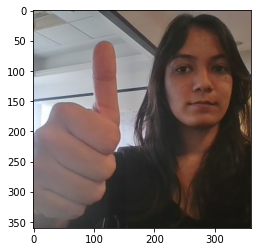

In [ ]:
#sample picture 
list_of_pictures[1]
image=io.imread(list_of_pictures[999])
plt.imshow(image)
plt.show
image.shape[0]

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
# Creating a custom Filter 
y = 84 # Width of the image
z = 84 # height
batch_size = 64

def generator(source_path, folder_list, batch_size, img_seq):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = img_seq   # the sequence of images from a folder
    while True:
        t = np.random.permutation(folder_list)   #random permutation of the foler list 
        num_batches = int(len(t)/batch_size) # canculating number of batches. 
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB. len =z
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder 
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32) #reading all images
                    if image.shape[1] == 160:   # resizing all images
                        image = resize(image[:,20:140,:],(84,84)).astype(np.float32)
                    else:
                        image = resize(image,(84,84)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] #reading and populating the matrix for z
                    batch_data[folder,idx,:,:,1] = image[:,:,1] #reading and populating the matrix for x
                    batch_data[folder,idx,:,:,2] = image[:,:,2] #reading and populating the matrix for y
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

            if (len(t)%batch_size) != 0:
                batch_data = np.zeros((len(t)%batch_size,len(img_idx),84,84,3))
                batch_labels = np.zeros((len(t)%batch_size,5))
                for folder in range(len(t)%batch_size):
                    imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                    for idx,item in enumerate(img_idx):
                        image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                        if image.shape[1] == 160:
                            image = resize(image[:,20:140,:],(84,84)).astype(np.float32)
                        else:
                            image = resize(image,(84,84)).astype(np.float32)

                        batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                        batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                        batch_data[folder,idx,:,:,2] = image[:,:,2] - 123

                    batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

                yield batch_data, batch_labels
        
        # write the code for the remaining data points which are left after full batches


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/gdrive/MyDrive/ColabNotebooks/Project_data/train'
val_path = '/content/gdrive/MyDrive/ColabNotebooks/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Model 1 (Conv3D with 30 epoch, batch of 64 and 18 images in a sequence)

In [12]:
#import tensorflow as tf
#from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

In [ ]:
# batch shape and sample generator

img_seq = [0,2,4,6,8,10,12,13,14,15,16,17,18,20,22,24,26,28]
sample_generator = generator(train_path, train_doc, 20, img_seq)
sample_batch_data, sample_batch_labels = next(sample_generator)
print(sample_batch_data.shape)

# validation batch sample
sample_val_generator = generator(val_path, val_doc, 20, img_seq)
sample_val_batch_data, sample_val_batch_labels = next(sample_val_generator)
print(sample_val_batch_data.shape)

Source path =  /content/gdrive/MyDrive/ColabNotebooks/Project_data/train ; batch size = 20
(20, 18, 84, 84, 3)
Source path =  /content/gdrive/MyDrive/ColabNotebooks/Project_data/val ; batch size = 20
(20, 18, 84, 84, 3)


In [ ]:
#sequential model

model = Sequential()
model.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same', input_shape=(18,84,84,3)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

# model.add(Dropout(0.25))

model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

# model.add(Dropout(0.25))

model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 18, 84, 84, 64)    5248      
                                                                 
 batch_normalization (BatchN  (None, 18, 84, 84, 64)   256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 18, 84, 84, 64)    0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 9, 42, 84, 64)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 9, 42, 84, 128)    221312    
                                                                 
 batch_normalization_1 (Batc  (None, 9, 42, 84, 128)   5

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size, img_seq)
val_generator = generator(val_path, val_doc, batch_size, img_seq)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]
#callbacks_list = [LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/gdrive/MyDrive/ColabNotebooks/Project_data/train ; batch size = 64
Epoch 1/30
11/11 [==============================] - 1991s 198s/step - loss: 3.7748 - categorical_accuracy: 0.3487 - val_loss: 15.5529 - val_categorical_accuracy: 0.2300
Epoch 2/30
11/11 [==============================] - 1230s 123s/step - loss: 1.7580 - categorical_accuracy: 0.5546 - val_loss: 12.0691 - val_categorical_accuracy: 0.2200
Epoch 3/30
11/11 [==============================] - 126s 13s/step - loss: 1.6940 - categorical_accuracy: 0.5331 - val_loss: 8.3089 - val_categorical_accuracy: 0.2300
Epoch 4/30
11/11 [==============================] - 125s 12s/step - loss: 1.3538 - categorical_accuracy: 0.6114 - val_loss: 8.6749 - val_categorical_accuracy: 0.2200
Epoch 5/30
11/11 [==============================] - 125s 12s/step - loss: 1.5598 - categorical_accuracy: 0.5631 - val_loss: 8.0500 - val_categorical_accuracy: 0.2500
Epoch 6/30
11/11 [==============================] - 119s 12s/step - loss:

In [33]:
def plotModelHistory(h):
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('No. of Epochs')
    ax[0].plot(h.history['loss'])   
    ax[0].plot(h.history['val_loss'])
    ax[0].legend(['loss','val_loss'])
    ax[0].title.set_text("Train loss vs Validation loss")

    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('No. of Epochs')
    ax[1].plot(h.history['categorical_accuracy'])   
    ax[1].plot(h.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    ax[1].title.set_text("Train accuracy vs Validation accuracy")
    plt.show()

    print("Max. Training Accuracy", max(h.history['categorical_accuracy']))
    print("Max. Validaiton Accuracy", max(h.history['val_categorical_accuracy']))

## MODEL 2 (COnV3D Different model - change in design , 12 images per X)

In [ ]:


img_seq = [4,6,8,10,12,14,16,18,20,22,24,26]
train_generator = generator(train_path, train_doc, batch_size, img_seq)
val_generator = generator(val_path, val_doc, batch_size, img_seq)

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
model_2 = Sequential()
model_2.add(Conv3D(32, (3,3,3), strides=(1,1,1), padding='same', input_shape=(len(img_seq),84,84,3)))
model_2.add(BatchNormalization())
model_2.add(Activation('elu'))
model_2.add(MaxPooling3D(pool_size=(1,2,2), strides=(1,2,2)))

model_2.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('elu'))
model_2.add(MaxPooling3D(pool_size=(1,2,2), strides=(1,2,2)))

# model.add(Dropout(0.25))

model_2.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('elu'))
model_2.add(MaxPooling3D(pool_size=(1,2,2), strides=(1,2,2)))

# model.add(Dropout(0.25))

model_2.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('elu'))
model_2.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model_2.add(Flatten())
model_2.add(Dropout(0.5))
model_2.add(Dense(256, activation='elu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(5, activation='softmax'))

In [ ]:
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model_2.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_2.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 12, 84, 84, 32)    2624      
                                                                 
 batch_normalization_8 (Batc  (None, 12, 84, 84, 32)   128       
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 12, 84, 84, 32)    0         
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 12, 42, 42, 32)   0         
 3D)                                                             
                                                                 
 conv3d_10 (Conv3D)          (None, 12, 42, 42, 64)    55360     
                                                                 
 batch_normalization_9 (Batc  (None, 12, 42, 42, 64)  

In [ ]:
model_2_history=model_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    #callbacks=callbacks_list, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
11/11 [==============================] - 81s 8s/step - loss: 3.4396 - categorical_accuracy: 0.3808 - val_loss: 10.4506 - val_categorical_accuracy: 0.2300
Epoch 2/30
11/11 [==============================] - 78s 8s/step - loss: 1.7336 - categorical_accuracy: 0.4716 - val_loss: 6.1664 - val_categorical_accuracy: 0.2200
Epoch 3/30
11/11 [==============================] - 85s 8s/step - loss: 1.5634 - categorical_accuracy: 0.4870 - val_loss: 6.0428 - val_categorical_accuracy: 0.2900
Epoch 4/30
11/11 [==============================] - 81s 8s/step - loss: 1.2621 - categorical_accuracy: 0.5764 - val_loss: 7.0641 - val_categorical_accuracy: 0.2300
Epoch 5/30
11/11 [==============================] - 83s 8s/step - loss: 1.1813 - categorical_accuracy: 0.6152 - val_loss: 5.9717 - val_categorical_accuracy: 0.2300
Epoch 6/30
11/11 [==============================] - 77s 8s/step - loss: 1.2648 - categorical_accuracy: 0.5764 - val_loss: 5.3626 - val_categorical_accuracy: 0.2600
Epoch 7/30
11/1

TypeError: ignored

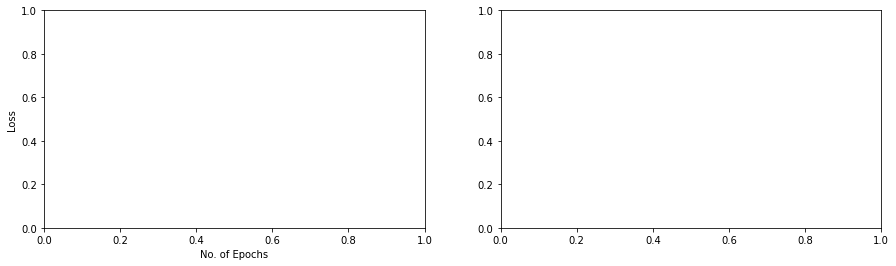

In [ ]:
plotModelHistory(model_2_history)

## Model 3: Convolutions + RNN using VGG16  GRU

In [28]:
def generator_RNN(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size)
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,15,120,120,3))
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = image[:,20:140,:].astype(np.float32)
                    else:
                        image = resize(image,(120,120)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,15,120,120,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = image[:,20:140,:].astype(np.float32)
                    else:
                        image = resize(image,(120,120)).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [30]:
batch_size = 16
num_epochs = 30

train_generator = generator_RNN(train_path, train_doc, batch_size)
val_generator = generator_RNN(val_path, val_doc, batch_size)

In [24]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [25]:
from keras.applications.vgg16 import VGG16   
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(120,120,3))
x = base_model.output
x = Flatten()(x)
#x.add(Dropout(0.5))
features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
    
for layer in base_model.layers:
    layer.trainable = False
        
model_3 = Sequential()
model_3.add(TimeDistributed(conv_model, input_shape=(15,120,120,3)))
model_3.add(GRU(32, return_sequences=True))
model_3.add(GRU(16))
model_3.add(Dropout(0.5))
model_3.add(Dense(8, activation='relu'))
model_3.add(Dense(5, activation='softmax'))

In [26]:
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model_3.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_3.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1 (TimeDis  (None, 15, 64)           15009664  
 tributed)                                                       
                                                                 
 gru_2 (GRU)                 (None, 15, 32)            9408      
                                                                 
 gru_3 (GRU)                 (None, 16)                2400      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 8)                 136       
                                                                 
 dense_6 (Dense)             (None, 5)                 45        
                                                      

In [31]:
model_3history= model_3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    #callbacks=callbacks_list, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/gdrive/MyDrive/ColabNotebooks/Project_data/train ; batch size = 16
Epoch 1/30
42/42 [==============================] - 6839s 166s/step - loss: 1.6742 - categorical_accuracy: 0.1870 - val_loss: 1.5923 - val_categorical_accuracy: 0.2400
Epoch 2/30
42/42 [==============================] - 91s 2s/step - loss: 1.5759 - categorical_accuracy: 0.2549 - val_loss: 1.5757 - val_categorical_accuracy: 0.2600
Epoch 3/30
42/42 [==============================] - 90s 2s/step - loss: 1.5839 - categorical_accuracy: 0.2428 - val_loss: 1.5294 - val_categorical_accuracy: 0.3100
Epoch 4/30
42/42 [==============================] - 91s 2s/step - loss: 1.5334 - categorical_accuracy: 0.2805 - val_loss: 1.5538 - val_categorical_accuracy: 0.2500
Epoch 5/30
42/42 [==============================] - 93s 2s/step - loss: 1.5288 - categorical_accuracy: 0.3017 - val_loss: 1.4767 - val_categorical_accuracy: 0.3700
Epoch 6/30
42/42 [==============================] - 92s 2s/step - loss: 1.4810 - cate

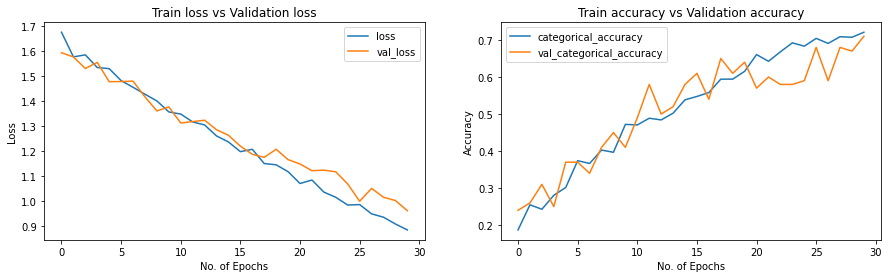

Max. Training Accuracy 0.7209653258323669
Max. Validaiton Accuracy 0.7099999785423279


In [35]:
plotModelHistory(model_3history)

### Model 3b Adding 30 more Epochs (total 60)

In [36]:
model_3history= model_3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    #callbacks=callbacks_list, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
42/42 [==============================] - 91s 2s/step - loss: 0.8893 - categorical_accuracy: 0.7481 - val_loss: 0.9689 - val_categorical_accuracy: 0.6700
Epoch 2/30
42/42 [==============================] - 91s 2s/step - loss: 0.8521 - categorical_accuracy: 0.7647 - val_loss: 1.0619 - val_categorical_accuracy: 0.6100
Epoch 3/30
42/42 [==============================] - 92s 2s/step - loss: 0.8151 - categorical_accuracy: 0.7768 - val_loss: 0.9121 - val_categorical_accuracy: 0.6800
Epoch 4/30
42/42 [==============================] - 89s 2s/step - loss: 0.8251 - categorical_accuracy: 0.7587 - val_loss: 0.9560 - val_categorical_accuracy: 0.6500
Epoch 5/30
42/42 [==============================] - 92s 2s/step - loss: 0.8259 - categorical_accuracy: 0.7677 - val_loss: 0.9387 - val_categorical_accuracy: 0.6600
Epoch 6/30
42/42 [==============================] - 93s 2s/step - loss: 0.7709 - categorical_accuracy: 0.7753 - val_loss: 0.9157 - val_categorical_accuracy: 0.6900
Epoch 7/30
42/42

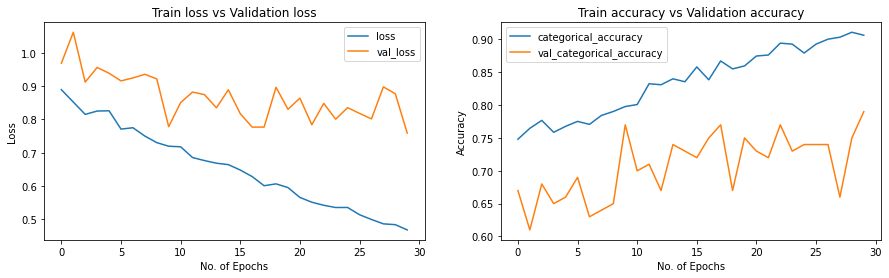

Max. Training Accuracy 0.9110105633735657
Max. Validaiton Accuracy 0.7900000214576721


In [37]:
plotModelHistory(model_3history)

## Model 3C additional 30 Epochs ( total 90)

In [38]:
model_3history= model_3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    #callbacks=callbacks_list, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
42/42 [==============================] - 93s 2s/step - loss: 0.4407 - categorical_accuracy: 0.9427 - val_loss: 0.7798 - val_categorical_accuracy: 0.7400
Epoch 2/30
42/42 [==============================] - 90s 2s/step - loss: 0.4365 - categorical_accuracy: 0.9276 - val_loss: 0.7827 - val_categorical_accuracy: 0.7400
Epoch 3/30
42/42 [==============================] - 91s 2s/step - loss: 0.4654 - categorical_accuracy: 0.9170 - val_loss: 0.8357 - val_categorical_accuracy: 0.7400
Epoch 4/30
42/42 [==============================] - 91s 2s/step - loss: 0.4191 - categorical_accuracy: 0.9186 - val_loss: 0.8429 - val_categorical_accuracy: 0.7400
Epoch 5/30
42/42 [==============================] - 92s 2s/step - loss: 0.4065 - categorical_accuracy: 0.9367 - val_loss: 0.8566 - val_categorical_accuracy: 0.7400
Epoch 6/30
42/42 [==============================] - 92s 2s/step - loss: 0.3915 - categorical_accuracy: 0.9201 - val_loss: 0.8182 - val_categorical_accuracy: 0.7300
Epoch 7/30
42/42

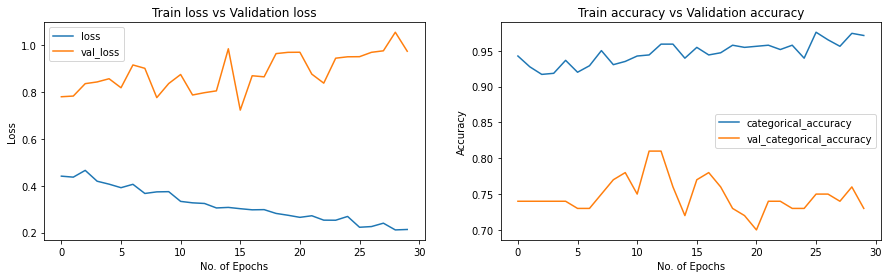

Max. Training Accuracy 0.9758672714233398
Max. Validaiton Accuracy 0.8100000023841858


In [39]:
plotModelHistory(model_3history)

## Model 4

In [ ]:
batch_size = 16
num_epochs = 60

train_generator = generator_RNN(train_path, train_doc, batch_size)
val_generator = generator_RNN(val_path, val_doc, batch_size)

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
  
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(120,120,3))
x = base_model.output
x = Flatten()(x)
#x.add(Dropout(0.5))
features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
    
for layer in base_model.layers:
    layer.trainable = False
        
model_4 = Sequential()
model_4.add(TimeDistributed(conv_model, input_shape=(15,120,120,3)))
model_4.add(GRU(32, return_sequences=True))
model_4.add(GRU(16))
model_4.add(Dropout(0.5))
model_4.add(Dense(8, activation='relu'))
model_4.add(Dense(5, activation='softmax'))

In [ ]:
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model_4.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_4.summary())

In [ ]:
model_4history= model_4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    #callbacks=callbacks_list, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plotModelHistory(model_4history)